## PSF quantification script

<details>
  <summary>>>Click to expand</summary>
    
Written by Nicholas Sofroniew, modified by Adam Glaser & Kevin Bishop

This script computes the average PSF size from a volume of diffraction limited beads for the purposes of characterizing microscope resolution.

Usage: A relatively small (~1mm^3 or less) data volume should be collected, ensuring SBR is moderately high (50 - 100x). The volume should be fused as a TIFF stack (16 bit, no downsampling, one channel per stack) sliced along the XY (highest resolution) plane. To achieve this, open the hdf5 dataset in BigStitcher, *Multiview > right-click > Interactively reorient sample...* Press *shift + Y* to orient the sample view in the XY (highest resolution) plane and click *Apply tranformation*. Define a bounding box (to fuse a subvolume if the dataset is large) and fuse to a compressed TIFF stack. Finally open the TIFF stack in FIJI (import as virtual stack for faster loading). Confirm that each single image shows the XY plane - the PSF should look circular and symmetric, not stretched. Click *Image > properties* and note the pixel sampling (width / height / depth; should all be the same) to input below.

Note: the script may take several hours to run (it will appear stuck on 'getting centers | Smoothing...')

**Coordinate convention**

*This is my current understanding, but the results don't fully make sense (Y res better than X res)*

    X: tile width (i.e. control code Y)

    Y: scan direction (i.e. control code X)

    Z: gravity direction (i.e. control code Z)
    
**Note on colormaps**

Heatmaps are colored using the [vik colormap](https://www.fabiocrameri.ch/colourmaps/) by Fabio Crameri, available as a python package via pip: ```pip install cmcrameri```. This is scientific colormap which is perceptually uniform and ordered, and is color-vision-deficiency friendly. The colormap is diverging and centered about the median PSF size. In other words, red colors indicate PSFs *larger* than the median while blue colors indicate PSFs *smaller* than the median, with color intensity indicating how far the value is from the median.

<details>


## Setup environment

In [1]:
import os
import numpy as np
import json
from skimage.io import imread
from skimage.io import imsave
from psf import compute
%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.colors import ListedColormap

from cmcrameri import cm
import pandas
import warnings
import time



## Define plotting style

In [20]:
# run this line regardless to reset any prior styles
plt.style.use('default')

# run this line for inline display
#plt.style.use('./styles/display.mplstyle')

# run this line to save for paper display
plt.style.use('./styles/nat_prot_heat.mplstyle')

## Define plotting functions

In [38]:
def plot_scatter(h_ax,
                 v_ax,
                 save_name,
                 data_in,
                 save_plot=True,
                 h_label='',
                 v_label='',
                 plot_title=''):
    
    # plot data
    fig, ax = plt.subplots()
    plt.scatter(data_in[h_ax]*sampling,
                data_in[v_ax],
                marker='.')
    
    # update labels
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)

    if v_label == '':
        v_label = v_ax + ' (μm)'
    plt.ylabel(v_label)
    
    plt.title(plot_title)

    plt.ylim(bottom=0)
    
    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
        
    return fig, ax

def plot_histo(h_ax,
               h_max_lim,
               save_name,
               data_in,
               anno='',
               save_plot=True,
               h_label='',
               v_label='',
               percentile_lim=[0.1,99.9]):
    
    
    # drop data outside percentile limits. To disable, set percentile_lim=[0,100]
    min_cutoff = np.percentile(data_in[h_ax],percentile_lim[0])
    max_cutoff = np.percentile(data_in[h_ax],percentile_lim[1])
    data_in = data_in.drop(data_in[(data_in[h_ax] < min_cutoff) | (data_in[h_ax] > max_cutoff)].index)

    # plot data
    fig, ax = plt.subplots()
    bins = np.linspace(0, h_max_lim, 31)
    plt.hist(data_in[h_ax], bins = bins, edgecolor = 'black',linewidth=0.5)
    
    # update labels
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)
    
    if v_label == '':
        v_label = 'N'
    plt.ylabel(v_label)
    
    data_med = round(np.median(data_in[h_ax]),3)
    data_std = round(np.std(data_in[h_ax]),3)
    
    plt.title(r'Median = ' + str(data_med) + r' μm   Stand. Dev. = ' + 
              str(data_std) + ' μm')
    
    # add annotation
    plt.annotate(anno, xy=(0.0*plt.xlim()[1], 0.9*plt.ylim()[1]))
    
    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
    
    return fig, ax

def plot_scatter_heat(h_ax,
                      v_ax,
                      color_ax,
                      save_name,
                      data_in,
                      save_plot=True,
                      h_label='',
                      v_label='',
                      c_label='',
                      plot_title='',
                      clim=[],
                      xlim=[],
                      ylim=[],
                      xticks=[],
                      yticks=[],
                      percentile_lim=[0.1,99.9],
                      base_map=''):
    
    
    if base_map == '':
        # to use built-in colormaps, uncomment line below
        base_map = mpl.colormaps['coolwarm']
        # base_map = cm.batlow
    
    # drop data outside percentile limits. To disable, set percentile_lim=[0,100]
    min_cutoff = np.percentile(data_in[color_ax],percentile_lim[0])
    max_cutoff = np.percentile(data_in[color_ax],percentile_lim[1])
    data_in = data_in.drop(data_in[(data_in[color_ax] < min_cutoff) | (data_in[color_ax] > max_cutoff)].index)

    # use autoscaled colormap (recommended)
    if clim == []:

        # find colormap range to center map at median data value
        med_val = np.median(data_in[color_ax])
        max_val = np.max(data_in[color_ax])
        min_val = np.min(data_in[color_ax])        

        reach = np.max([max_val - med_val, med_val - min_val])

        cmap_lower = 0.5 - 0.5*(med_val-min_val)/reach
        cmap_upper = 0.5 + 0.5*(max_val-med_val)/reach
        cmap_nsteps = int((cmap_upper - cmap_lower)*256)

        if(cmap_nsteps < 128):
            warnings.warn('Autoscaled colormap is significantly truncated - specify explicit clim')
            
        # truncate colormap to new range
        cmap_full = base_map
        cmp = ListedColormap(cmap_full(np.linspace(cmap_lower, cmap_upper, cmap_nsteps)))
    
    # use explicitly definied colormap range
    else:
        cmp = base_map
            
    # plot data
    fig,ax = plt.subplots()
    ax.set_aspect('equal')

    #fig = plt.figure()
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    plt.scatter(data_in[h_ax]*sampling,
                data_in[v_ax]*sampling,
                marker='.',
                c=data_in[color_ax],
                cmap=cmp)
    cbar = plt.colorbar(format='%0.1f')
    
    # use explicitly definied colormap range
    if not clim == []:
        plt.clim(clim)
        
    # update labels
    if c_label == '':
        c_label = color_ax + ' (μm)'
    cbar.set_label(c_label)
    
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)

    if v_label == '':
        v_label = v_ax + ' (μm)'
    plt.ylabel(v_label)
        
    plt.title(plot_title)
    
    # set axis bounds
    if xlim != []:
        plt.xlim(xlim)
    if ylim != []:
        plt.ylim(ylim)
    if xticks != []:
        ax.xaxis.set_ticks(xticks)
    if yticks != []:
        ax.yaxis.set_ticks(yticks)

    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
    
    return fig, ax


## Define parameters

In [4]:
sampling = 0.2454022 # um/px - see instructions above
wavelength = 638.0 # nm
NA = 0.4 * 1.56 # approximate collection NA
bead_size = 0.150 # um
windowUm = [8, 4, 4] # um - generally a few times the expected resolution. Too big may slow down script, 
                     # too small may truncate PSFs.

options = {'pxPerUmLat':1.0/sampling,
           'pxPerUmAx':1.0/sampling,
           'wavelength':wavelength,
           'NA':NA,
           'bead_size':bead_size,
           'windowUm':windowUm,
           'thresh':0.1}
#options['thresh'] = 0.1

# tif stack should be placed in its own directory
data_base_path = 'H:\\Kevin\\OTLS4_ECi-beads_256px_638-2197-7o5-2535'
tiff_name = 'fused_tp_0_ch_0.tif'

**Example:**


<div>
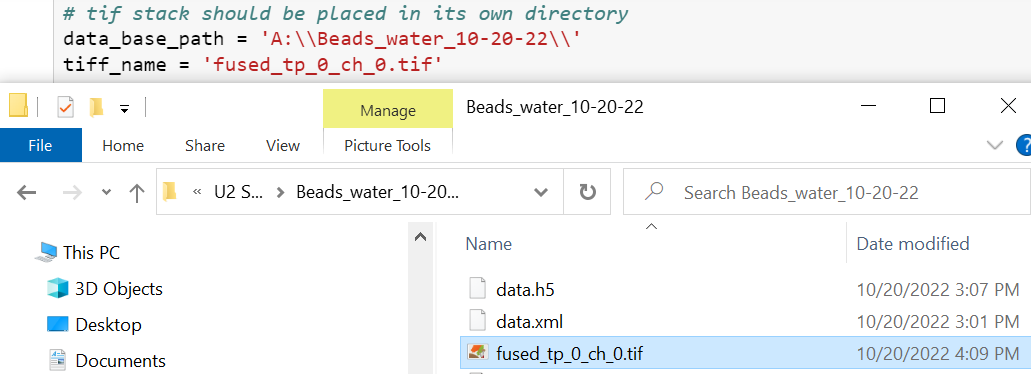
</div>

## Compute PSFs
Run this cell to generate new PSF data (may take several hours to run)

In [ ]:
try: data
except NameError:
    print('Computing PSFs data')
    
    start = time.time()
    
    tiff_path = os.path.join(data_base_path,tiff_name)
    im = imread(tiff_path, plugin='tifffile')
    data, smoothed = compute(im, options)
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Execution time: {:0>2}hrs {:0>2}mins {:05.2f}secs".format(int(hours),int(minutes),seconds))
    
else: print('Error data is already defined! Delete \'data\' variable (\'del data\') and try again')


Computing PSFs data


## Load PSF data
Run this cell to load saved PSF data (that has been previously generated by this script)

In [5]:
try: data
except NameError:
    print('Loading data')
    data = pandas.read_csv(os.path.join(data_base_path,'PSF_data.csv'), delimiter=',')
    print('Done')
else: print('Error data is already defined! Delete \'data\' variable (\'del data\') and try again')


Loading data
Done


## Plot PSF stats

<IPython.core.display.Javascript object>


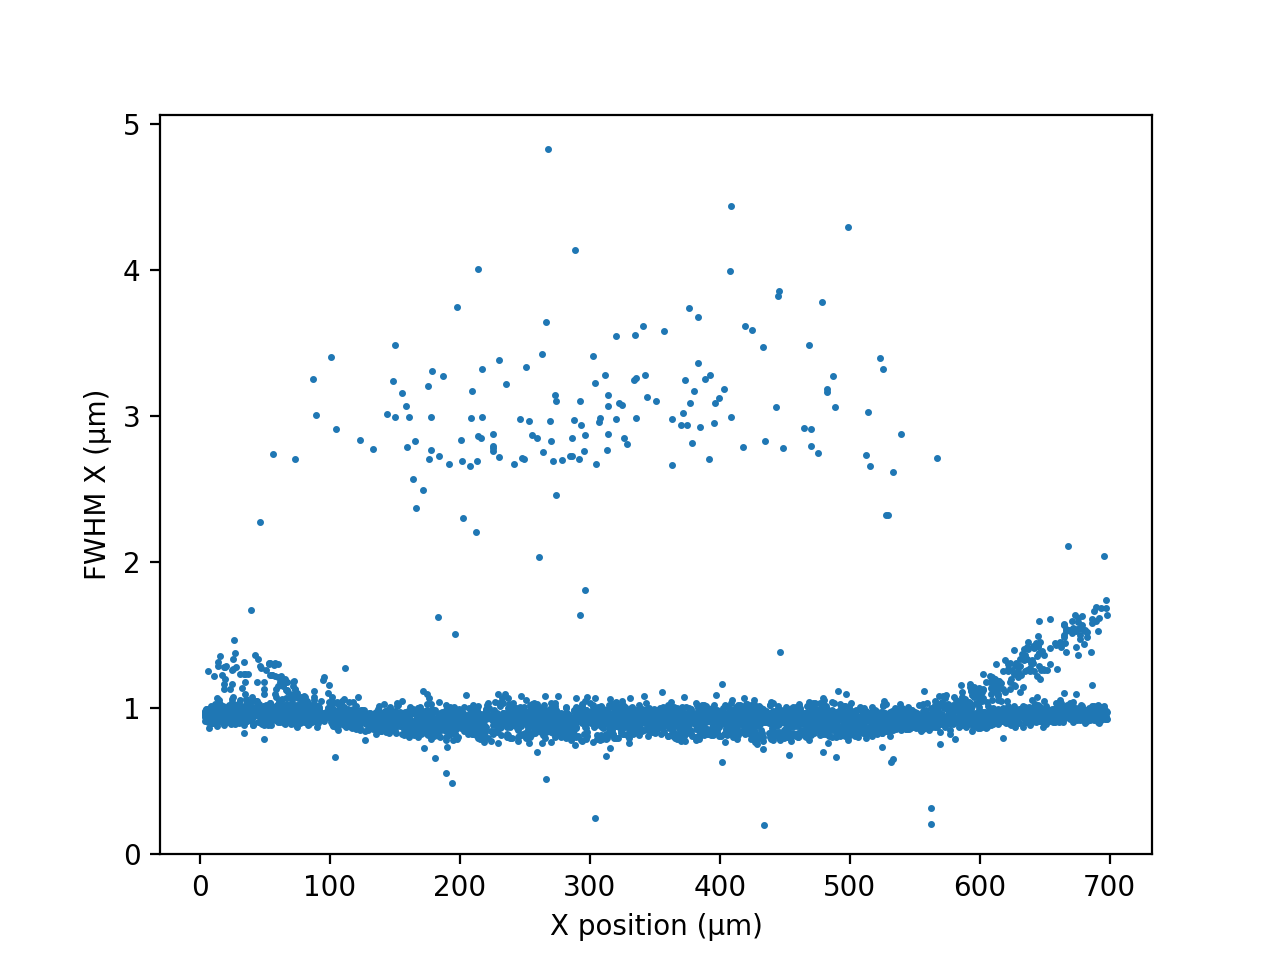

Plot NOT saved!


In [6]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_x'
v_label = 'FWHM X (μm)'

save_name = 'x_depth_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

<IPython.core.display.Javascript object>


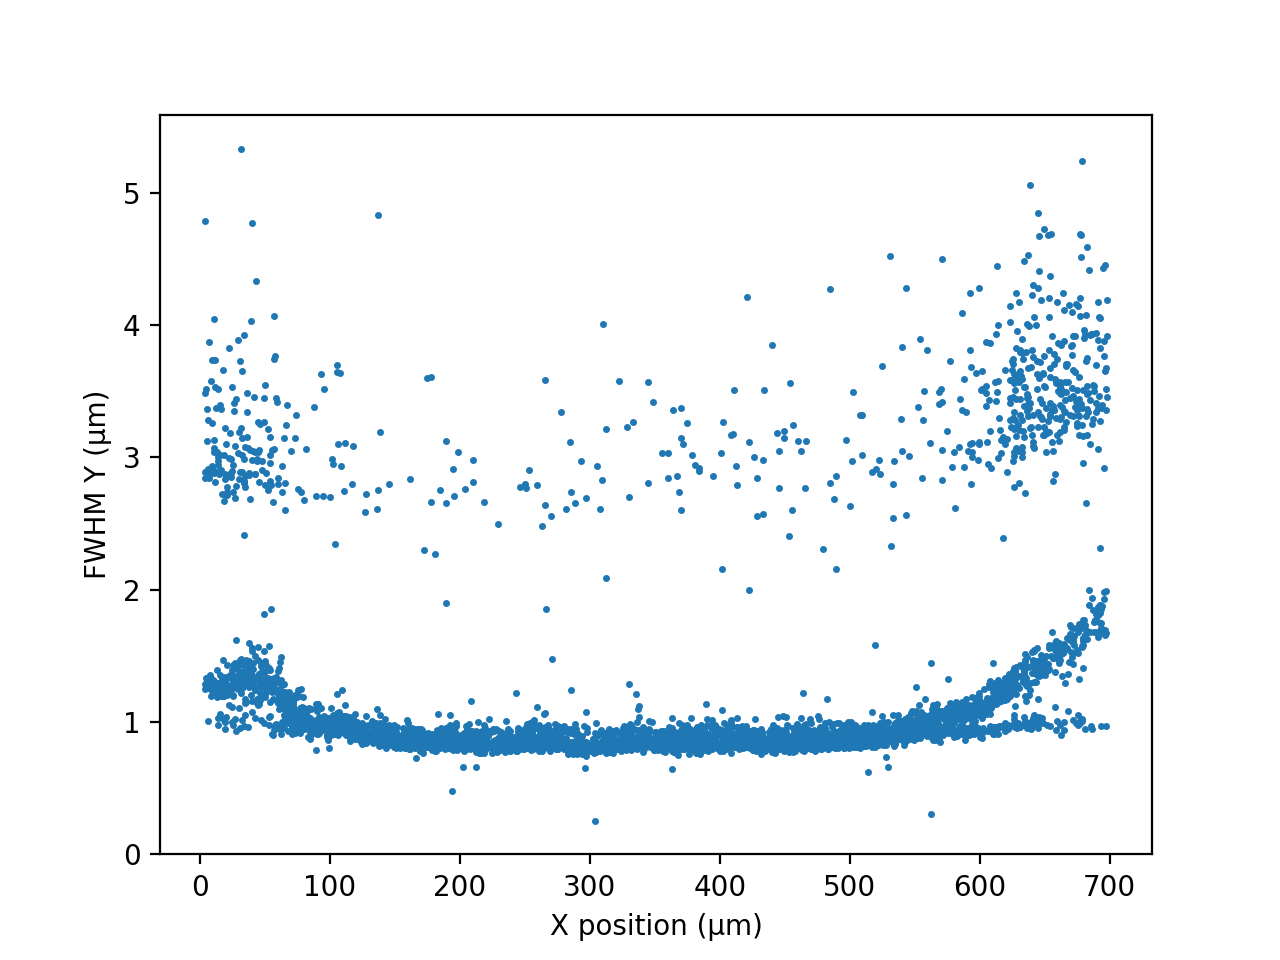

Plot NOT saved!


In [7]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_y'
v_label = 'FWHM Y (μm)'

save_name = 'y_depth_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

<IPython.core.display.Javascript object>


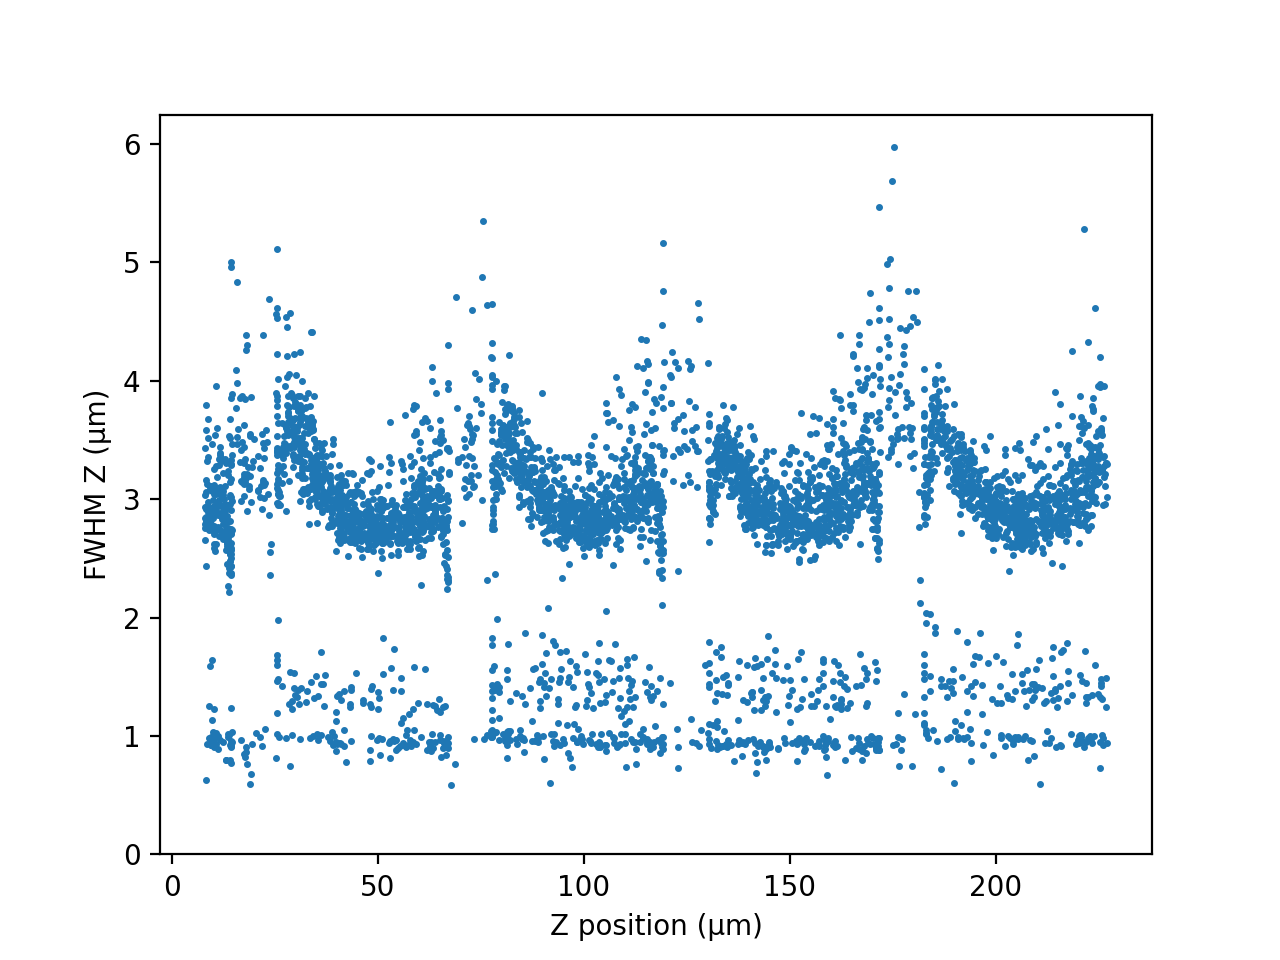

Plot NOT saved!


In [8]:
h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_depth_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

C:\Users\AERB\AppData\Local\Temp\ipykernel_9616\162045237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one_tile['z_center'] -= tile_min/sampling


<IPython.core.display.Javascript object>


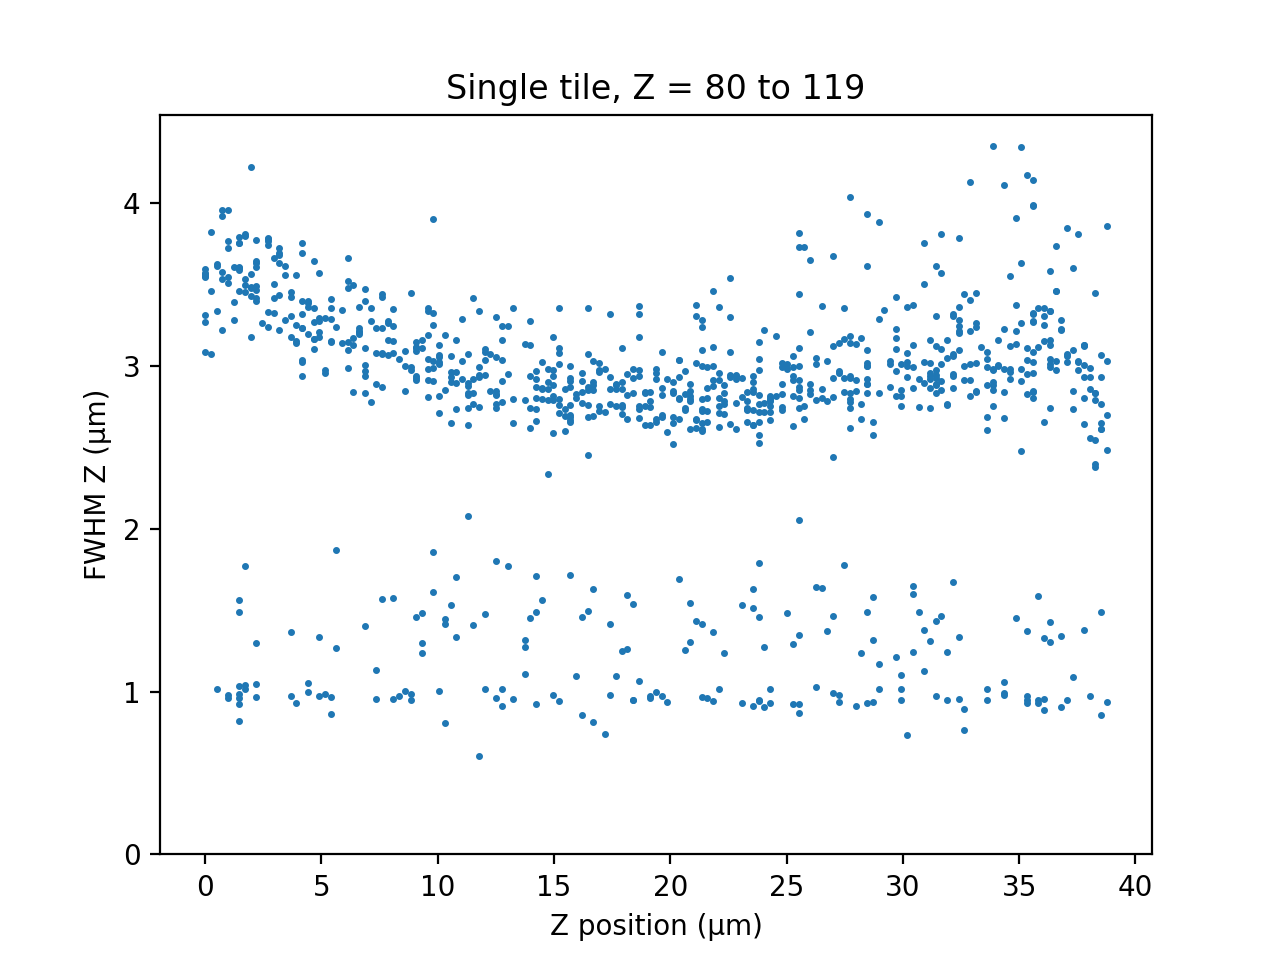

Plot NOT saved!


In [9]:
# plot only one tile
# NOTE: tile boundaries must be manually adjusted based on plot above

tile_min = 80
tile_max = 119

data_one_tile = data[(data['z_center']*sampling > tile_min) & (data['z_center']*sampling < tile_max)] 
data_one_tile['z_center'] -= tile_min/sampling

h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_depth_plot_single_tile.pdf'
title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)

plot_scatter(h_ax,
             v_ax,
             save_name,
             data_one_tile,
             save_plot=False,
             plot_title=title_string,
             h_label=h_label,
             v_label=v_label,)


<IPython.core.display.Javascript object>


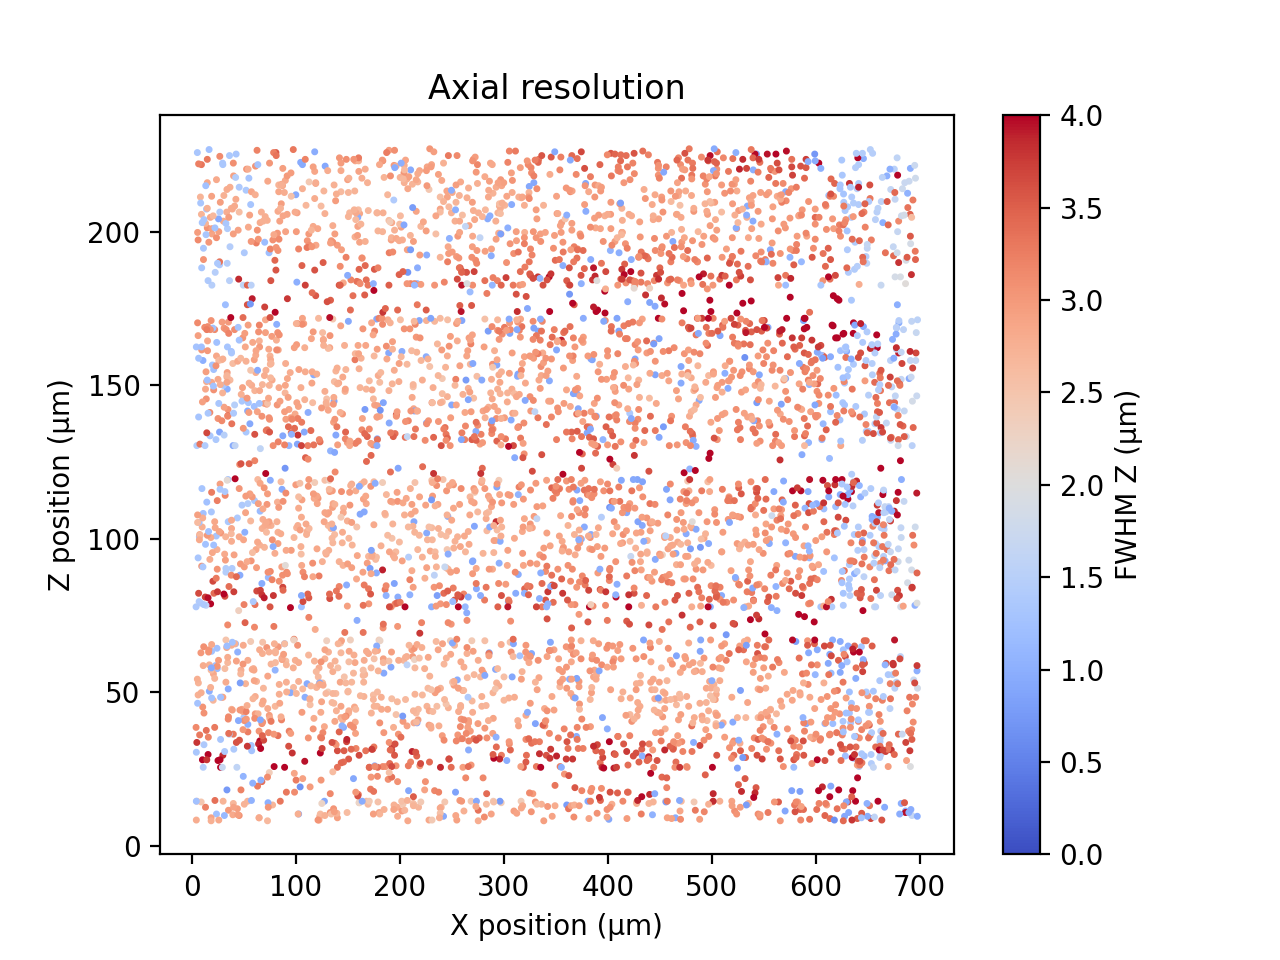

Plot NOT saved!


In [10]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

save_name = 'defocused_xy-z_heat_plot_single_tile.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data,
                  save_plot=False,
                  clim=[0,4],
                  plot_title='Axial resolution',
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  base_map = mpl.colormaps['coolwarm'],
                  #base_map =cm.nuuk
                 )

# use cool warm for paper (when scale bar is consistent across plots)
# vik original w/ autoscaling

<IPython.core.display.Javascript object>


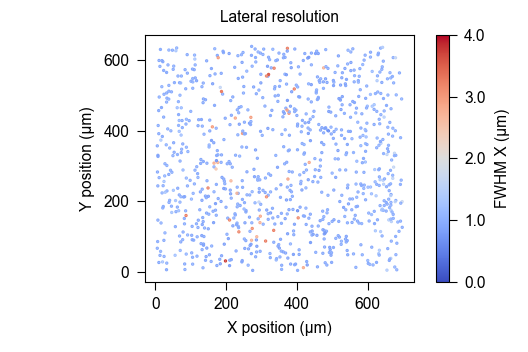

Saving plot


(<Figure size 264x176 with 2 Axes>,
 <Axes: title={'center': 'Lateral resolution'}, xlabel='X position (μm)', ylabel='Y position (μm)'>)

In [42]:
#plt.style.use('./styles/nat_prot_histo.mplstyle')

#### LATERAL ####

h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'y_center'
v_label = 'Y position (μm)'

color_ax = 'FWHM_x'
c_label = 'FWHM X (μm)'

#title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)
title_string = 'Lateral resolution'

save_name = 'well-aligned_heat_plot_set-color.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data_one_tile,
                  save_plot=True,
                  clim=[0,4],
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  plot_title=title_string,
                  #xlim=[0,None],
                  #ylim=[0,None],
                  #percentile_lim=[0,100]
                  yticks = [0, 200, 400, 600],
                 )


<IPython.core.display.Javascript object>


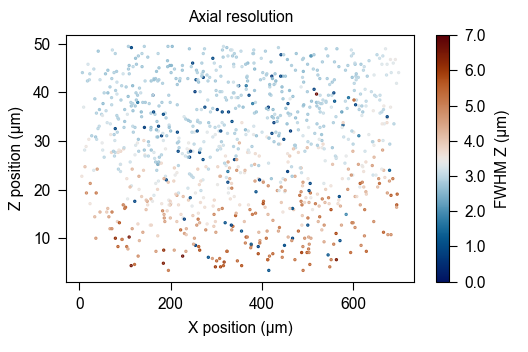

Saving plot


In [77]:
#### AXIAL ####

h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

#title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)
title_string = 'Axial resolution'

save_name = 'defocused_axial_heat_plot_set-color.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data_one_tile,
                  save_plot=True,
                  clim=[0,7],
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  plot_title=title_string,
                  #xlim=[0,None],
                  #ylim=[0,None],
                  #percentile_lim=[0,100]
                 )

<IPython.core.display.Javascript object>


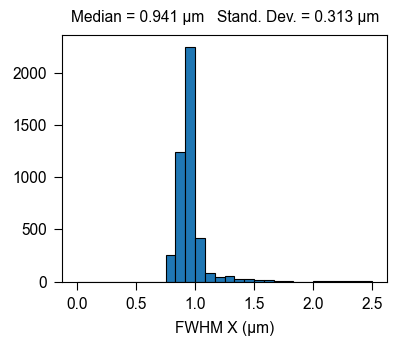

Plot NOT saved!


In [13]:
plt.style.use('./styles/nat_prot_histo.mplstyle')

h_ax = 'FWHM_x'
h_label = 'FWHM X (μm)'
v_label = 'Number of beads'
h_max_lim = 2.5
save_name = 'x_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=False,
           h_label=h_label,
           v_label=v_label,
           percentile_lim=[1,99]
          )

<IPython.core.display.Javascript object>


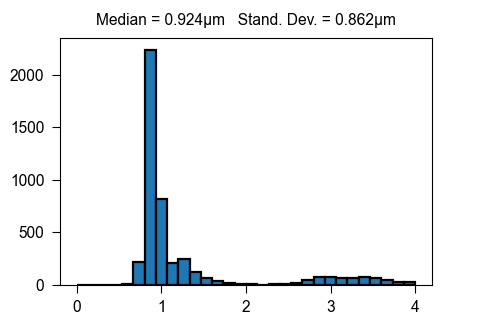

Saving plot


In [75]:
h_ax = 'FWHM_y'
h_label = 'FWHM Y (μm)'
h_max_lim = 4.0
save_name = 'y_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=True,
           h_label=h_label)

<IPython.core.display.Javascript object>


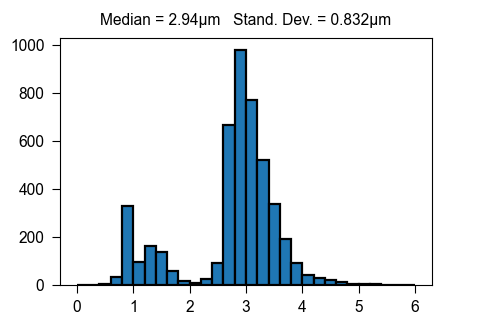

Saving plot


In [76]:
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
h_max_lim = 6.0
save_name = 'z_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=True,
           h_label=h_label)

<IPython.core.display.Javascript object>


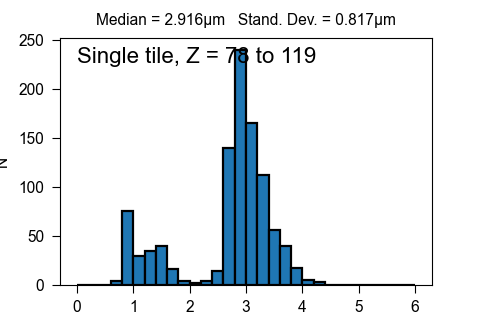

Saving plot


In [77]:
# plot single tile only (defined above)
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
h_max_lim = 6.0
save_name = 'z_histo_single_tile.pdf'
anno_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data_one_tile,
           anno=anno_string,
           save_plot=True,
           h_label=h_label)


***
***
*The rest of the script cannot be run with loaded (previously computed) data as the complete PSFs are not stored. To run the below sections, the PSFs must be recomputed from the raw data (above)*

## Plot average PSFs (slices)
Use caution when interpreting average PSFs - some aberrations will distort the PSFs in opposite ways at each side of the field of view, etc. For instance, if a PSF stretches to have an upward tail at the left side of the FOV and a downward tail at the right side of the FOV, the average PSF would still look symmetric (as these distortions would cancel each other out).

In [22]:
average_psf = np.zeros(data['bead'][0].shape)
for i in range (data['bead'].shape[0]):
    average_psf = average_psf + data['bead'][i]

average_psf = average_psf/data['bead'].shape
print(average_psf.shape)
fig, axs = plt.subplots(1,3)

XY = average_psf[int(average_psf.shape[0]/2),:,:]
YZ = average_psf[:,int(average_psf.shape[1]/2),:]
XZ = average_psf[:,:,int(average_psf.shape[2]/2)]

axs[0].imshow(XY, vmin = 0, vmax = 1, cmap='gray');
axs[0].axis('off');
axs[0].set_title('XY')

axs[1].imshow(YZ, vmin = 0, vmax = 1, cmap='gray');
axs[1].axis('off');
axs[1].set_title('YZ')

axs[2].imshow(XZ, vmin = 0, vmax = 1, cmap='gray');
axs[2].axis('off');
axs[2].set_title('XZ')



AttributeError: 'str' object has no attribute 'shape'

In [25]:
save_path = os.path.join(data_base_path, 'XZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'YZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(YZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'XY.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XY*255).astype('uint8'))
else:
    raise Exception('File already exists')

## Save raw data

In [26]:
save_path = os.path.join(data_base_path, 'PSF_data.csv')
if not os.path.exists(save_path):
    data.to_csv(os.path.join(data_base_path, 'PSF_data.csv'))
else:
    raise Exception('File already exists')

## Plot max projection of bead locations

<IPython.core.display.Javascript object>


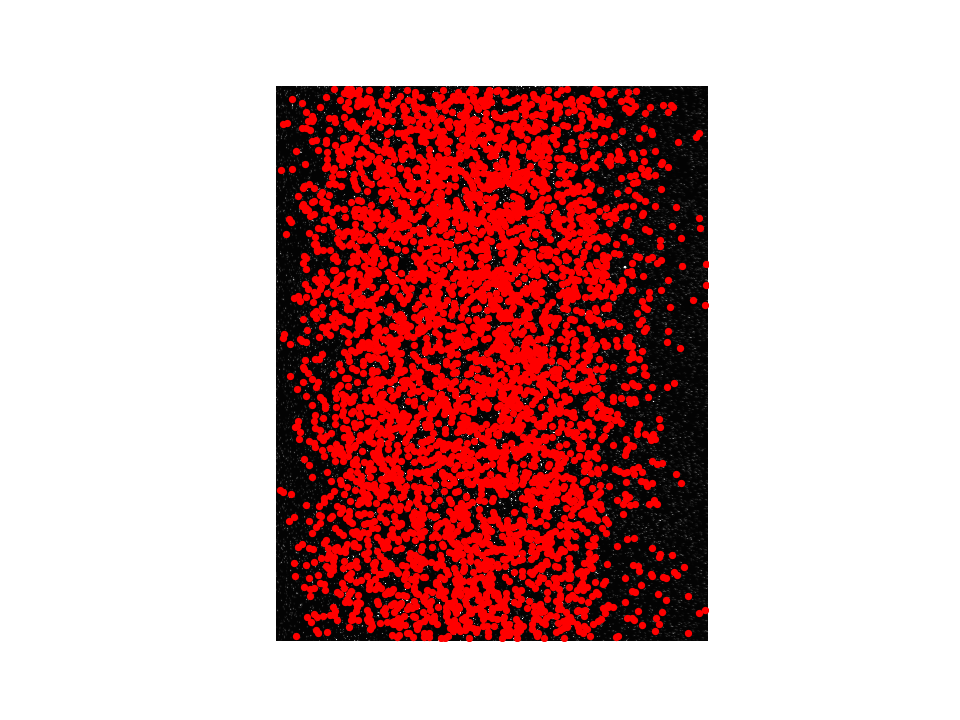

In [27]:
plt.subplots()
plt.imshow(smoothed, vmin = 0, vmax = 10000, cmap='gray');
plt.plot(data['x_center'], data['y_center'], 'r.', ms=5);

# uncomment below to zoom in on plot
# plt.xlim([0, 0+smoothed.shape[0]/4])
# plt.ylim([smoothed.shape[1]/4, 500])
plt.axis('off');

## Plot average PSFs (projections)

<IPython.core.display.Javascript object>


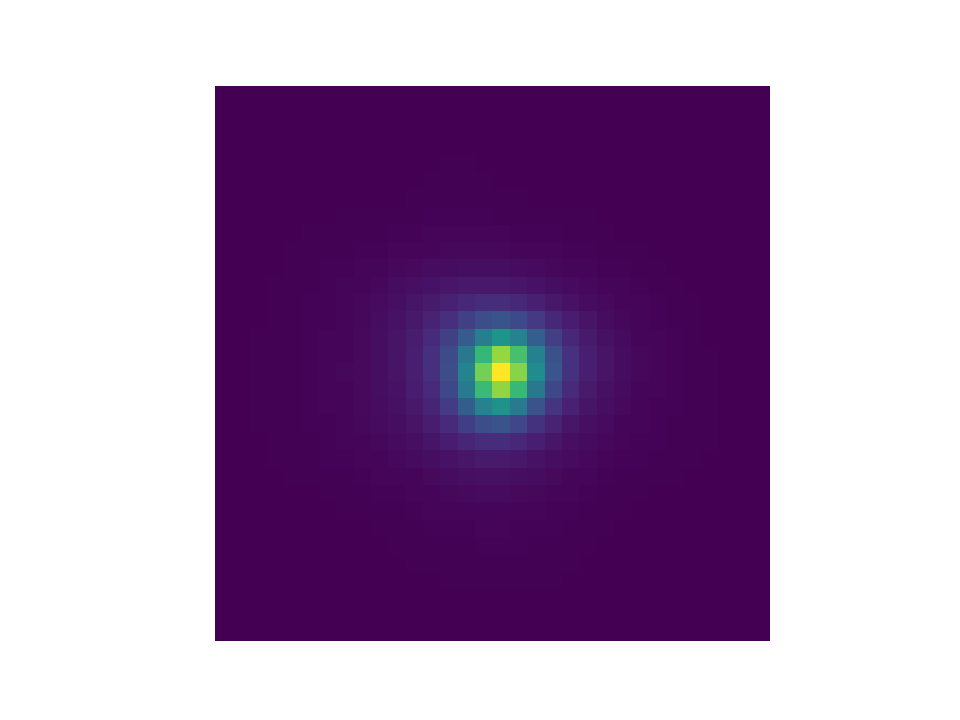

In [28]:
plt.subplots()
plt.imshow(average_psf.mean(axis=0));
plt.axis('off');

<IPython.core.display.Javascript object>


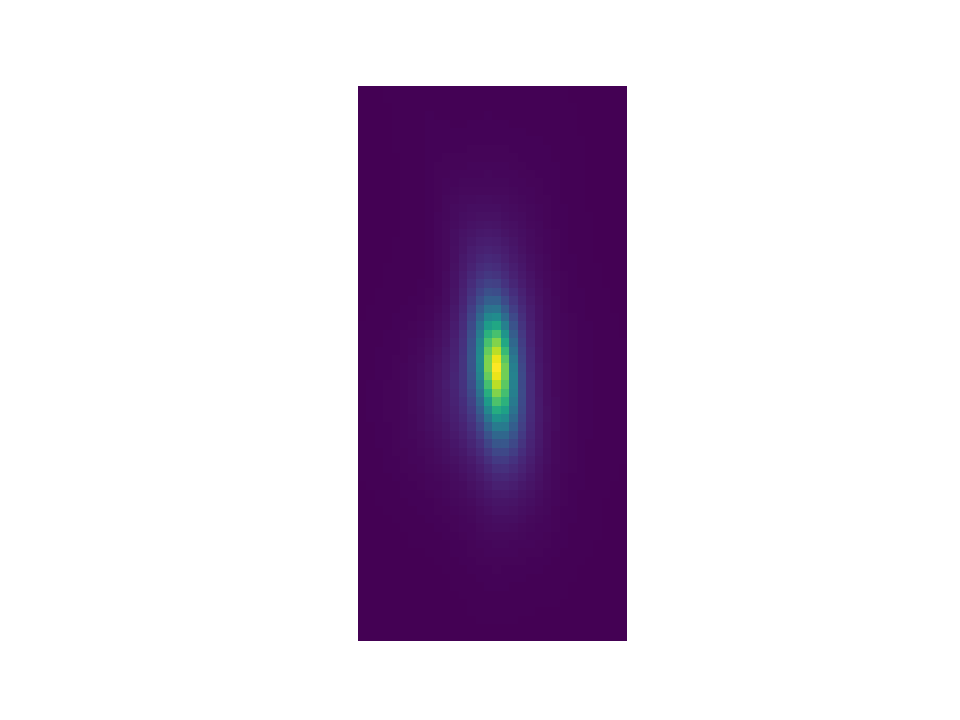

In [29]:
plt.subplots()
plt.imshow(average_psf.mean(axis=1), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

<IPython.core.display.Javascript object>


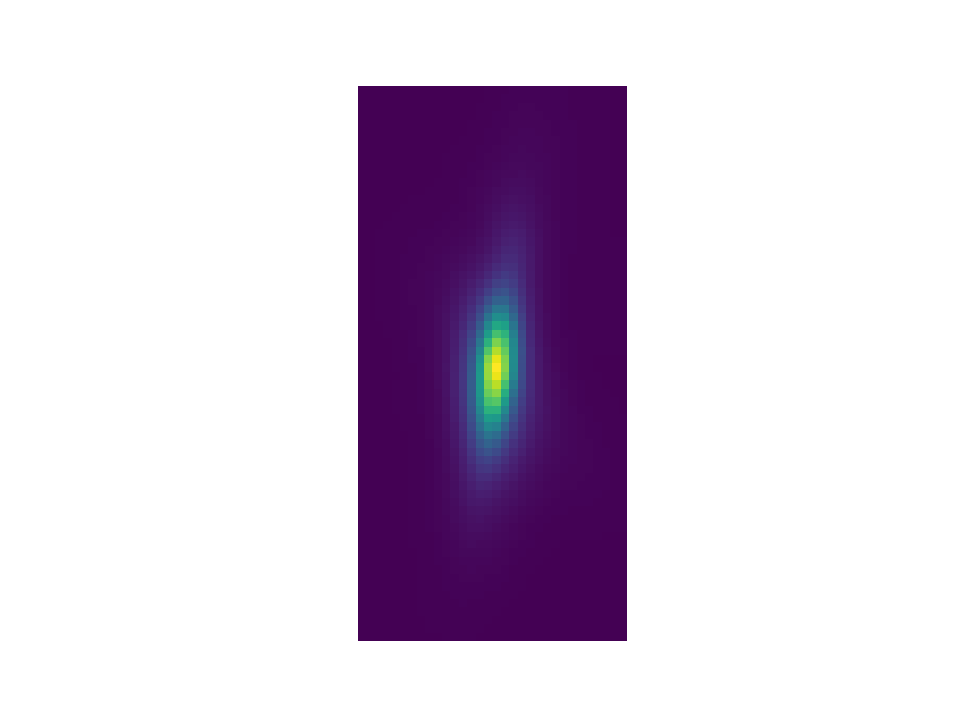

In [30]:
plt.subplots()
plt.imshow(average_psf.mean(axis=2), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');